In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time


# 超参数
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 0.003
USE_DROPOUT = True
USE_BATCHNORM = True
DEVICE = "cuda:0"

# 数据加载
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# 训练
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    loss_history = []
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f} seconds")
    return loss_history, duration

# 测试
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# 参数统计
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 优化器
def get_optimizer(name, model):
    if name == 'adam':
        return optim.Adam(model.parameters(), lr=LEARNING_RATE)
    elif name == 'adamw':
        return optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    elif name == 'sgd':
        return optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer")
    
# 激活函数选择器
def get_activation(name):
    if name == 'relu':
        return nn.ReLU()
    elif name == 'tanh':
        return nn.Tanh()
    elif name == 'sigmoid':
        return nn.Sigmoid()
    else:
        raise ValueError("Unsupported activation")
    
class CustomCNN(nn.Module):
    def __init__(self, activation='relu', use_dropout=False, use_batchnorm=False):
        super(CustomCNN, self).__init__()
        act = get_activation(activation)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32) if use_batchnorm else nn.Identity(),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25) if use_dropout else nn.Identity()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
            act,
            nn.MaxPool2d(2),
            nn.Dropout(0.25) if use_dropout else nn.Identity()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256),
            act,
            nn.Dropout(0.5) if use_dropout else nn.Identity()
        )
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.fc2(x)
        return x


Files already downloaded and verified
Files already downloaded and verified


In [2]:
## different activation
loss_histories = {}
acc = {}
for ACTIVATION in ['relu', 'tanh', 'sigmoid']:
    OPTIMIZER = 'adamw'

    model = CustomCNN(activation=ACTIVATION, use_dropout=USE_DROPOUT, use_batchnorm=USE_BATCHNORM).to(DEVICE)
    optimizer = get_optimizer(OPTIMIZER, model)
    criterion = nn.CrossEntropyLoss()

    loss_history, training_time = train_model(model, train_loader, criterion, optimizer, EPOCHS)
    accuracy = evaluate_model(model, test_loader)
    print(f"optimizer = {OPTIMIZER}, activation = {ACTIVATION}\nTotal parameters: {count_parameters(model)}\nacc = {accuracy}")
    loss_histories[ACTIVATION] = loss_history
    acc[ACTIVATION] = accuracy

    del model

Epoch [1/40], Loss: 1.8858
Epoch [2/40], Loss: 1.6294
Epoch [3/40], Loss: 1.5364
Epoch [4/40], Loss: 1.4641
Epoch [5/40], Loss: 1.4193
Epoch [6/40], Loss: 1.3830
Epoch [7/40], Loss: 1.3589
Epoch [8/40], Loss: 1.3238
Epoch [9/40], Loss: 1.3115
Epoch [10/40], Loss: 1.2936
Epoch [11/40], Loss: 1.2791
Epoch [12/40], Loss: 1.2674
Epoch [13/40], Loss: 1.2484
Epoch [14/40], Loss: 1.2348
Epoch [15/40], Loss: 1.2092
Epoch [16/40], Loss: 1.1931
Epoch [17/40], Loss: 1.1757
Epoch [18/40], Loss: 1.1640
Epoch [19/40], Loss: 1.1582
Epoch [20/40], Loss: 1.1489
Epoch [21/40], Loss: 1.1418
Epoch [22/40], Loss: 1.1179
Epoch [23/40], Loss: 1.1033
Epoch [24/40], Loss: 1.0999
Epoch [25/40], Loss: 1.0897
Epoch [26/40], Loss: 1.0852
Epoch [27/40], Loss: 1.0724
Epoch [28/40], Loss: 1.0584
Epoch [29/40], Loss: 1.0584
Epoch [30/40], Loss: 1.0483
Epoch [31/40], Loss: 1.0412
Epoch [32/40], Loss: 1.0313
Epoch [33/40], Loss: 1.0206
Epoch [34/40], Loss: 1.0167
Epoch [35/40], Loss: 1.0125
Epoch [36/40], Loss: 1.0096
E

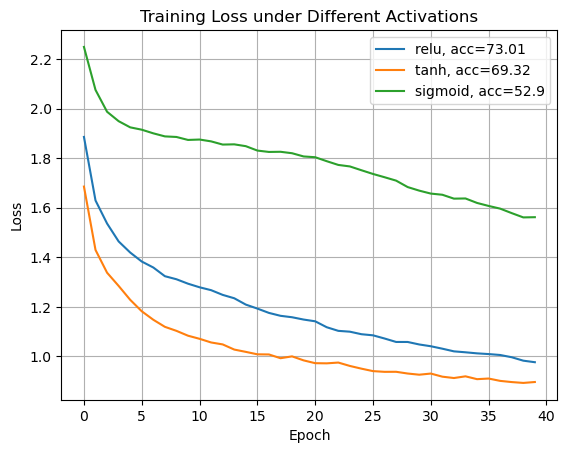

In [ ]:
# loss可视化
for legend, loss_history in loss_histories.items():
    plt.plot(loss_history, label=f"{legend}, acc={acc[legend]}%")
plt.title("Training Loss under Different Activations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("D1_loss_act.png")